# fastbook 13: Implement ResNet

In [1]:
from fastai.vision.all import *

## Let's try manual convolution for MNIST_SAMPLE!

In [2]:
top_edge = tensor([[-1,-1,-1],
                   [0,0,0],
                   [1,1,1]]).float()

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

<AxesSubplot:>

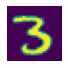

In [4]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3)

In [5]:
im3_t = tensor(im3)
im3_t[:3,:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [6]:
im3_t[:3,:3] * top_edge.sum()

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [7]:
df = pd.DataFrame(im3_t[:10,:20])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [8]:
df.style.background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [9]:
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [10]:
(im3_t[4:7,6:9]*top_edge).sum()

tensor(762.)

In [11]:
(im3_t[5:8,6:9]*top_edge).sum()

tensor(135.)

In [12]:
(im3_t[7:10,17:20]*top_edge).sum()

tensor(-29.)

In [13]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2]*kernel).sum()

In [14]:
apply_kernel(5,7, top_edge)

tensor(762.)

In [15]:
tmp = []
for i in range(1,5):
    l = [(i,j) for j in range(1,5)]
    tmp.append(l)
tmp

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

In [16]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

<AxesSubplot:>

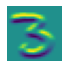

In [17]:
def apply_kernel_(k):
    ''''apply specified 'kernel' to all 28*28 dimention'''
    return tensor([[apply_kernel(i,j,k) for j in range(1,27)] for i in range(1,27)])

show_image(apply_kernel_(top_edge))

<AxesSubplot:>

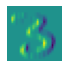

In [18]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0],]).float()
show_image(apply_kernel_(left_edge))

In [19]:
diag1_edge = torch.eye(3).flip(0)
diag1_edge[1,0] = -1.
diag1_edge[0,1] = -1.
diag1_edge

tensor([[ 0., -1.,  1.],
        [-1.,  1.,  0.],
        [ 1.,  0.,  0.]])

In [20]:
diag2_edge = diag1_edge.flip(1);diag2_edge

tensor([[ 1., -1.,  0.],
        [ 0.,  1., -1.],
        [ 0.,  0.,  1.]])

In [21]:
edge_kernels = torch.stack([
    left_edge,
    top_edge,
    diag1_edge,
    diag2_edge,
])
edge_kernels.shape

torch.Size([4, 3, 3])

In [22]:
dls = DataBlock(
    (ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label).dataloaders(path)
xb, yb = first(dls.valid)
xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [23]:
xb, yb = to_cpu(xb), to_cpu(yb)

kernel shpae is
$ ({out\_channels}, \frac{{in\_channels}}{{groups}}, kH , kW) $
, where ${groups}$ could divide the ${in\_channels}$ into # of the ${groups}$ to be masked by the # of ${out\_channels}$ respectively.

In [24]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape,edge_kernels[:,None,:,:].shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]), torch.Size([4, 1, 3, 3]))

In [25]:
edge_kernels = edge_kernels.unsqueeze(1)
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

<AxesSubplot:>

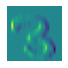

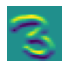

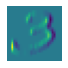

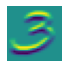

In [26]:
show_image(batch_features[0,0])
show_image(batch_features[0,1])
show_image(batch_features[1,0])
show_image(batch_features[1,1])

In [27]:
def new_len(n, ks, stride): return (n + 2*(ks//2) - ks) // stride + 1 # After Conv2d
new_len(28, 3, 1)

28

In [28]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [29]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, 3, padding=1)
)
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [30]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [31]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [32]:
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16,32),
    conv(32, 2, act=False),
    Flatten(),
)
Learner(dls, simple_cnn).summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [33]:
xb, yb = xb.to('cuda'), yb.to('cuda')
simple_cnn(xb).shape

torch.Size([64, 2])

In [34]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [35]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.071222,0.050959,0.980373,00:07
1,0.024415,0.025981,0.991168,00:04


In [36]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [37]:
m[0].weight.shape, m[0].bias.shape, 

(torch.Size([4, 1, 3, 3]), torch.Size([4]))

In [38]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

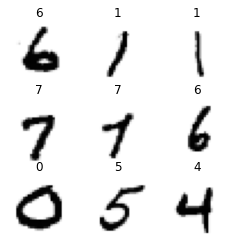

In [39]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training', 'testing'),
        get_y=parent_label,
        batch_tfms=Normalize(),
    ).dataloaders(path, bs=bs)
dls = get_dls()
dls.show_batch(figsize=(4,4))

In [40]:
def simple_cnn():
    return nn.Sequential(
        conv(1, 8, ks=5),
        conv(8, 16),
        conv(16,32),
        conv(32,64),
        conv(64, 10, act=False),
        Flatten(),
    )
Learner(dls, simple_cnn()).summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 14 x 14    
Conv2d                                    208        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 7 x 7     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 4 x 4     
Conv2d                                    4640       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 2 x 2     
Conv2d                                    18496      True      
ReLU                                          

In [41]:
from fastai.callback.hook import *

def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

learn = fit()

/root/mambaforge/lib/python3.9/site-packages/fastai/callback/core.py:72: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.308644,2.303676,0.113500,00:59


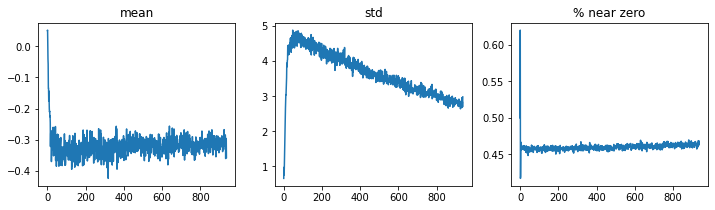

In [42]:
learn.activation_stats.plot_layer_stats(0)

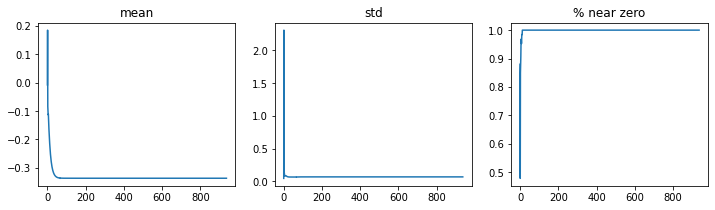

In [45]:
learn.activation_stats.plot_layer_stats(-2)

In [46]:
dls = get_dls(512)
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.378445,0.206369,0.935300,01:11


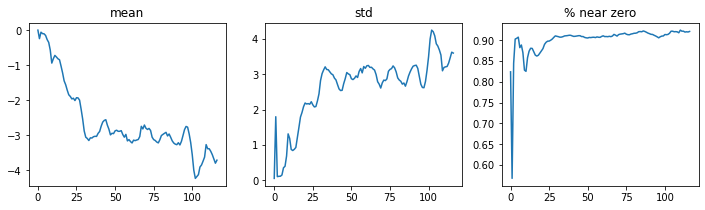

In [47]:
learn.activation_stats.plot_layer_stats(-2)

In [48]:
from fastai.callback.hook import *

def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, 0.06)
    return learn

learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.221753,0.077879,0.976000,00:55


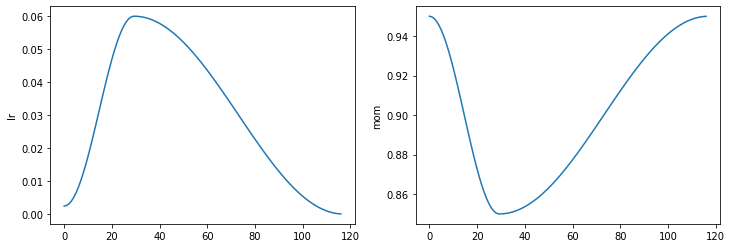

In [49]:
learn.recorderr.plot_sched()

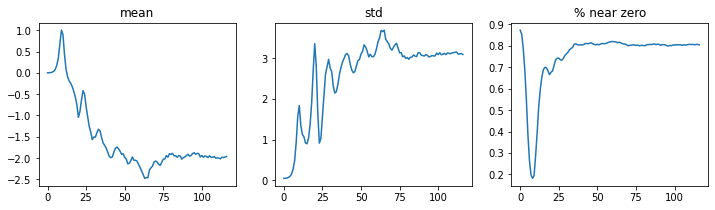

In [50]:
learn.activation_stats.plot_layer_stats(-2)

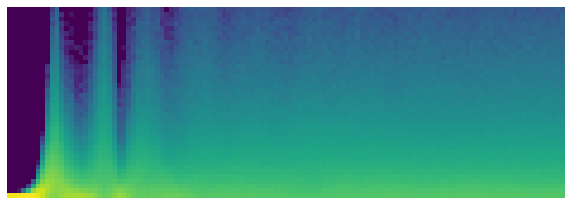

In [51]:
learn.activation_stats.color_dim(-2)

In [53]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    res = nn.Sequential(res, nn.BatchNorm2d(nf))
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

learn = fit()

/root/mambaforge/lib/python3.9/site-packages/fastai/callback/core.py:72: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.133346,0.056620,0.985500,00:53


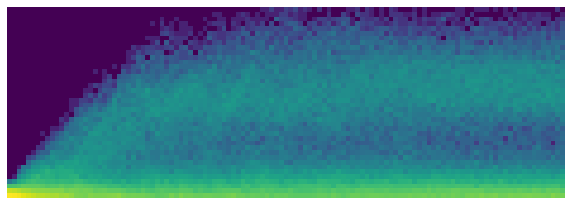

In [54]:
learn.activation_stats.color_dim(-2)

In [56]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, 0.06)
    return learn

learn = fit(5, lr=0.1)
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.212073,0.116812,0.964700,01:09
1,0.082356,0.093984,0.970900,01:00
2,0.048300,0.032620,0.989900,00:53
3,0.029639,0.034675,0.989700,00:55
4,0.016229,0.021613,0.992700,00:50


epoch,train_loss,valid_loss,accuracy,time
0,0.221145,0.103979,0.969600,00:53
1,0.083494,0.053522,0.983800,00:51
2,0.052213,0.045990,0.986000,01:04


KeyboardInterrupt: 